<a href="https://colab.research.google.com/github/hekmat-ashqer/MLJourney2024/blob/main/Stroke%20Prediction/Stroke%20Prediction%20Model%20Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Stroke Prediction Model Development

By Hikmat Ashqar

- LogReg, Random Forest, or KNN :
-
This task uses the dataset related to strokent.  The target vector is whether the person will have a stroke (1) or not (0
- we will try to build the best model we can to diagnose stroke and report.​

## Data Loading & inspection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:

fpath = "C:/Users/hekmat.ashqar/Desktop/DATA Science/jupyter/week 7/stroke.csv"
df = pd.read_csv(fpath)
df.head(100)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1192,Female,31,0,0,No,Govt_job,Rural,70.66,27.2,never smoked,0
1,77,Female,13,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,59200,Male,18,0,0,No,Private,Urban,60.56,33.0,never smoked,0
3,24905,Female,65,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
4,24257,Male,4,0,0,No,children,Rural,90.42,16.2,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2070,Male,52,0,0,Yes,Private,Urban,95.85,29.6,smokes,0
96,40371,Female,47,0,0,Yes,Private,Urban,62.47,26.5,never smoked,0
97,72703,Female,54,0,0,Yes,Private,Urban,75.52,28.7,formerly smoked,0
98,65413,Female,64,0,0,Yes,Private,Urban,55.64,43.4,never smoked,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1137 non-null   int64  
 1   gender             1137 non-null   object 
 2   age                1137 non-null   object 
 3   hypertension       1137 non-null   int64  
 4   heart_disease      1137 non-null   int64  
 5   ever_married       1137 non-null   object 
 6   work_type          1137 non-null   object 
 7   Residence_type     1137 non-null   object 
 8   avg_glucose_level  1137 non-null   float64
 9   bmi                1085 non-null   float64
 10  smoking_status     1137 non-null   object 
 11  stroke             1137 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 106.7+ KB


In [ ]:
df.isna().sum()

id                    0
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  52
smoking_status        0
stroke                0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df['gender'].value_counts()


Female    642
Male      494
Other       1
Name: gender, dtype: int64

In [ ]:
df['age'].value_counts()


79     26
57     24
78     24
52     23
81     22
       ..
3       7
35      7
12      6
4       6
*82     1
Name: age, Length: 84, dtype: int64

we will drop one value from gender calss
and correct age class type

In [ ]:
# drop this value as it will affect the gender class
indices_to_drop = df[df['gender'] == 'Other'].index
df.drop(indices_to_drop, inplace=True)
df['age'] = df['age'].replace('*82', '82')
df['age'] = df['age'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1136 entries, 0 to 1136
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1136 non-null   int64  
 1   gender             1136 non-null   object 
 2   age                1136 non-null   int32  
 3   hypertension       1136 non-null   int64  
 4   heart_disease      1136 non-null   int64  
 5   ever_married       1136 non-null   object 
 6   work_type          1136 non-null   object 
 7   Residence_type     1136 non-null   object 
 8   avg_glucose_level  1136 non-null   float64
 9   bmi                1084 non-null   float64
 10  smoking_status     1136 non-null   object 
 11  stroke             1136 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 110.9+ KB


In [ ]:
df['smoking_status'].value_counts()


never smoked       416
Unknown            352
formerly smoked    204
smokes             164
Name: smoking_status, dtype: int64

### helper function reporting

In [ ]:
### metrics function

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax




def explore_numeric(df, x, figsize=(6,5) ):

  nulls =  df[x].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,])
  else:
    temp_df = df

  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100

  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")


# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax


# We will be reproducing thie plot many times, so let's turn it into a short-term function
def plot_cv_results(gs, param_name='param_logisticregression__C', logx = True):
    # Making a dataframe with cv_results_
  cv_results = pd.DataFrame(gs.cv_results_)
  # Save the train/test scores with values for C
  scores = cv_results[[param_name,'mean_train_score','mean_test_score']]
  scores = scores.set_index(param_name)
  ## Plot the training vs test scores vs. C
  ax = scores.plot(y=['mean_test_score','mean_train_score'],
              style='o-',logx=logx)
  ax.set(ylabel=gs.scoring)
  print(scores['mean_test_score'])
  return ax

## Data Preproccesiong

In [ ]:
# Validation Split
X = df.drop(['stroke','id'], axis=1)
#X = df.drop(['stroke'], axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# Check class balance
y_train.value_counts()

0    749
1    103
Name: stroke, dtype: int64

In [ ]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
#impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [ ]:
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_mean, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


In [ ]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)

## 1) Logistic Regression


### Model

In [ ]:
# Instantiate a default decision tree
lr_model = LogisticRegression( max_iter=1000, random_state=42)
# Make a pipeline to scale the data and fit a model
lr_model_pipe = make_pipeline(preprocessor, lr_model)
# Fit the model on the training data
lr_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       749
           1       0.48      0.15      0.22       103

    accuracy                           0.88       852
   macro avg       0.69      0.56      0.58       852
weighted avg       0.84      0.88      0.85       852



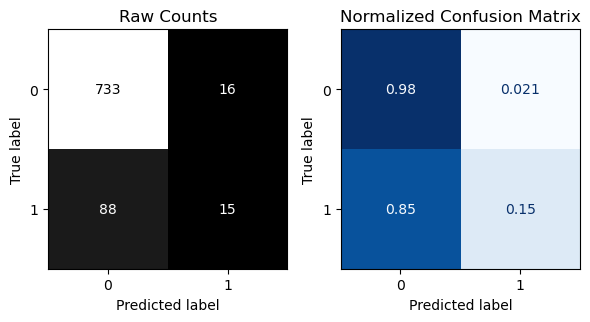


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       250
           1       0.38      0.09      0.14        34

    accuracy                           0.87       284
   macro avg       0.63      0.53      0.54       284
weighted avg       0.83      0.87      0.84       284



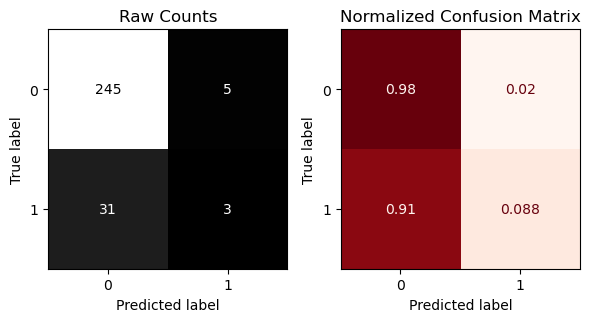

In [ ]:
results = evaluate_classification(lr_model_pipe,X_train, y_train, X_test, y_test,output_dict=True)


as above result show we need to make tuning for decision threshold to make sure our recall is high as this is what we will try to focus on

### threshold tuning



In [ ]:
test_probs = lr_model_pipe.predict_proba(X_test)
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
  """Converts float value probabilities into int value predictions.
  If the probability of class 1 is greater than the threshold, the prediction is 1
  Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
  predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
  return predictions
# Convert the model's probability predictions to class predictions
# With a decision threshold of .2
#test_preds = convert_probs_to_preds(test_probs, .25)
#test_preds[:5]
#ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens')

In [ ]:
# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)
# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []
# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(test_probs, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))

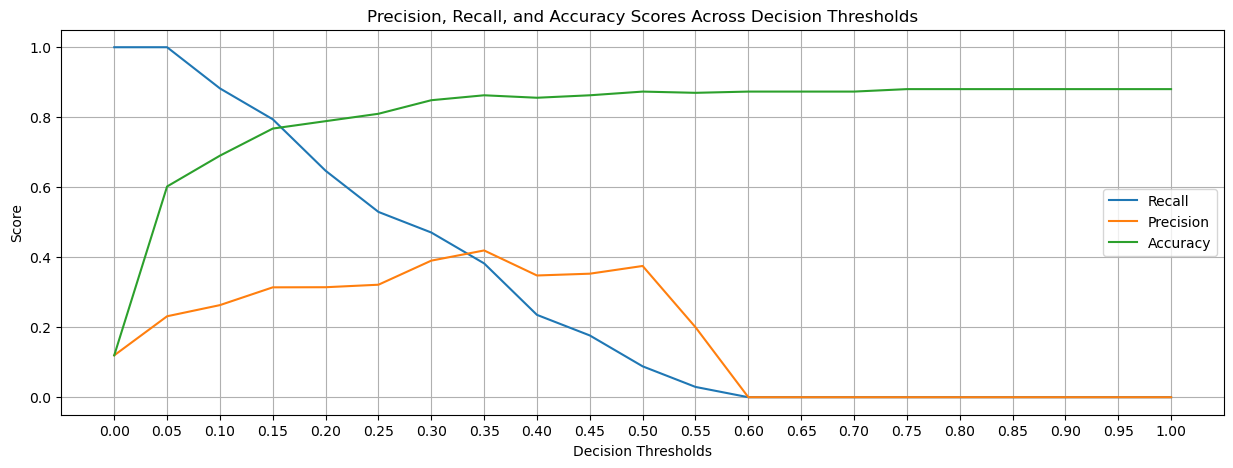

In [ ]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show()

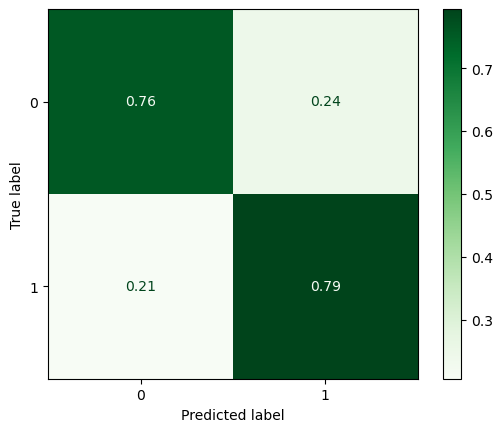

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       250
           1       0.31      0.79      0.44        34

    accuracy                           0.76       284
   macro avg       0.64      0.78      0.65       284
weighted avg       0.89      0.76      0.80       284



In [ ]:
# Convert probabilites to class labels with a decision threshold of 0.3
test_preds = convert_probs_to_preds(test_probs, .14)
# Display a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true',
                                        cmap='Greens')
plt.show()
# Print a classification report
print(classification_report(y_test, test_preds))

### Logistic Regression Hyperparameters



In [ ]:
lr_model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'Residence_type',
          'smoking_status'],
         dtype='object'))],
                     verb

In [ ]:
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__class_weight' :  [None, 'balanced'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
              'logisticregression__class_weight' :  [None, 'balanced'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000] }
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
                           'logisticregression__class_weight' :  [None, 'balanced'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000]}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
                             'logisticregression__class_weight' :  [None, 'balanced'],
               'logisticregression__penalty' : [None]}
# Now make a list of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]

In [ ]:
## Warning: this gridsearch may take 5-10 minutes to run!!
# Instantiate gridsearch
gs = GridSearchCV(lr_model_pipe, param_grid, verbose = 5, n_jobs = -1,
                  scoring='recall_macro')
# Fit the gs on the training data only
gs.fit(X_train, y_train)
gs.best_params_


Fitting 5 folds for each of 160 candidates, totalling 800 fits


{'logisticregression__C': 0.01,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       749
           1       0.30      0.81      0.44       103

    accuracy                           0.75       852
   macro avg       0.63      0.77      0.64       852
weighted avg       0.88      0.75      0.79       852



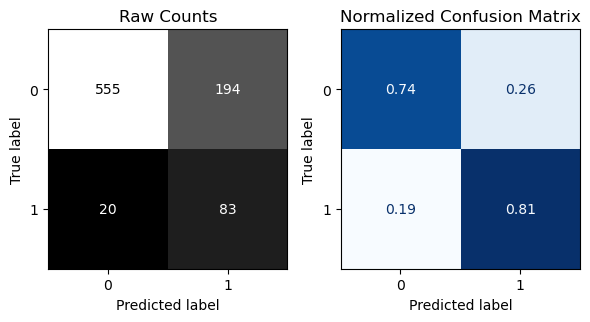


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       250
           1       0.30      0.85      0.44        34

    accuracy                           0.74       284
   macro avg       0.64      0.79      0.64       284
weighted avg       0.89      0.74      0.79       284



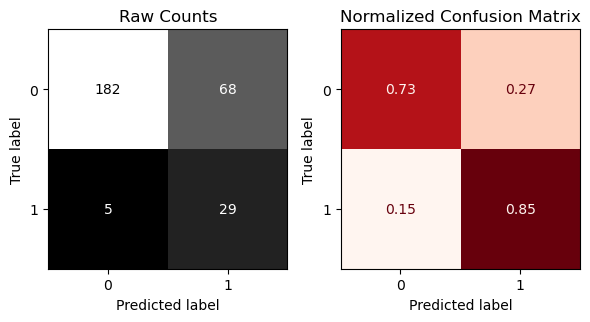

In [ ]:
# Evalaute the best model
best_logreg = gs.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)

### Which combination of hyperparameters led to the best-tuned model?
-
{'logisticregression__C': 0.01,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}


## 2) k-nearest neighbors

### model

In [ ]:
# Initialize and train a default KNN model
knn_model = KNeighborsClassifier()
# Make a pipeline to scale the data and fit a model
knn_model_pipe = make_pipeline(preprocessor, knn_model)
# Fit the model on the training data
knn_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       749
           1       0.66      0.26      0.38       103

    accuracy                           0.89       852
   macro avg       0.78      0.62      0.66       852
weighted avg       0.88      0.89      0.87       852



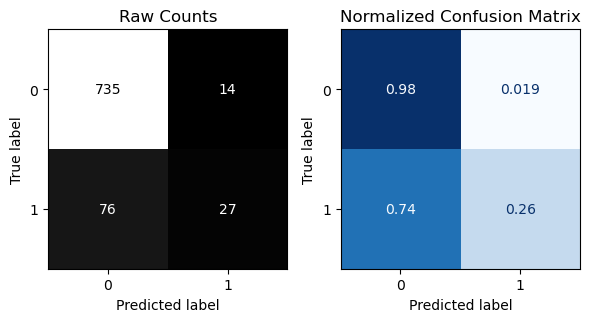


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       250
           1       0.36      0.12      0.18        34

    accuracy                           0.87       284
   macro avg       0.63      0.54      0.55       284
weighted avg       0.83      0.87      0.84       284



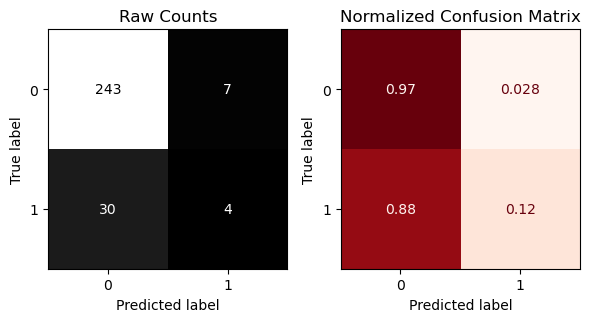

In [ ]:
results = evaluate_classification(knn_model_pipe,X_train, y_train, X_test, y_test,output_dict=True)


In [ ]:
# Define the parameter grid for KNN
knn_param_grid = {'kneighborsclassifier__n_neighbors': range(1, 31,2), 'kneighborsclassifier__weights': ['uniform', 'distance']}

knn_param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 31,2),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}


# Grid search
knn_grid_search = GridSearchCV(knn_model_pipe, knn_param_grid, cv=3, scoring='recall_macro')
knn_grid_search.fit(X_train, y_train)
knn_grid_search.best_params_


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(hand...
                                                                         Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': range(1, 31, 2),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='recall_macro')

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       103

    accuracy                           1.00       852
   macro avg       1.00      1.00      1.00       852
weighted avg       1.00      1.00      1.00       852



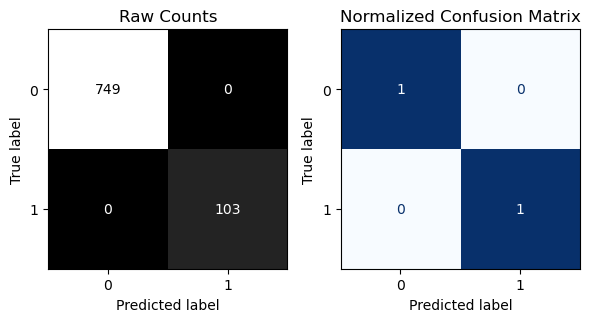


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       250
           1       0.23      0.35      0.28        34

    accuracy                           0.78       284
   macro avg       0.57      0.60      0.58       284
weighted avg       0.82      0.78      0.80       284



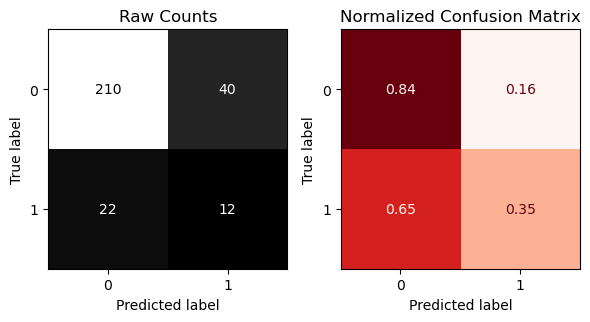

In [ ]:
best_knn_model = knn_grid_search.best_estimator_
evaluate_classification(best_knn_model, X_train, y_train, X_test, y_test)

In [ ]:
knn_grid_search.best_params_

{'kneighborsclassifier__metric': 'chebyshev',
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__weights': 'uniform'}

### Which combination of hyperparameters led to the best-tuned model?


{'kneighborsclassifier__metric': 'chebyshev',
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__weights': 'uniform'}

In [ ]:
# Instantiate a default decision tree
dec_tree_class =DecisionTreeClassifier(random_state = 42)
# Make a pipeline to scale the data and fit a model
dec_tree_pipe = make_pipeline(preprocessor, dec_tree_class)
# Fit the model on the training data
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       103

    accuracy                           1.00       852
   macro avg       1.00      1.00      1.00       852
weighted avg       1.00      1.00      1.00       852



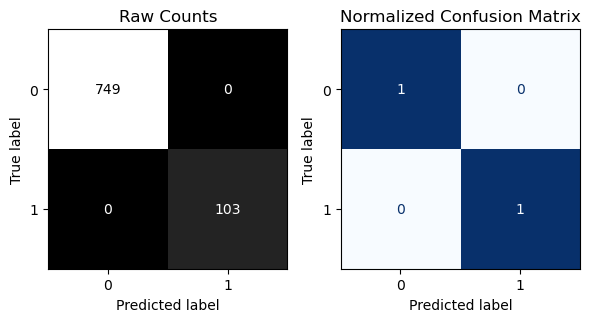


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       250
           1       0.31      0.35      0.33        34

    accuracy                           0.83       284
   macro avg       0.61      0.62      0.61       284
weighted avg       0.84      0.83      0.83       284



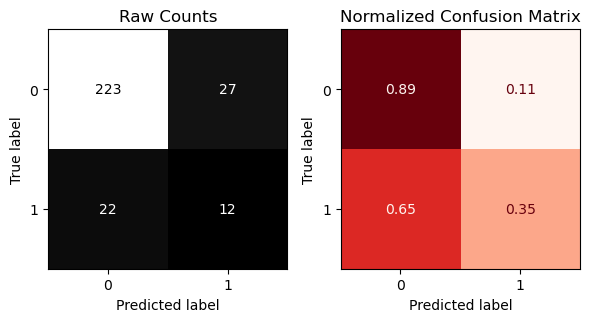

In [ ]:
results = evaluate_classification(dec_tree_pipe,X_train, y_train, X_test, y_test,output_dict=True)


## RandomForest

In [ ]:
# Initialize and train a default random forest model
rf_model = RandomForestClassifier(random_state=42)
# Make a pipeline to scale the data and fit a model
rf_model_pipe = make_pipeline(preprocessor, rf_model)
# Fit the model on the training data
rf_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       103

    accuracy                           1.00       852
   macro avg       1.00      1.00      1.00       852
weighted avg       1.00      1.00      1.00       852



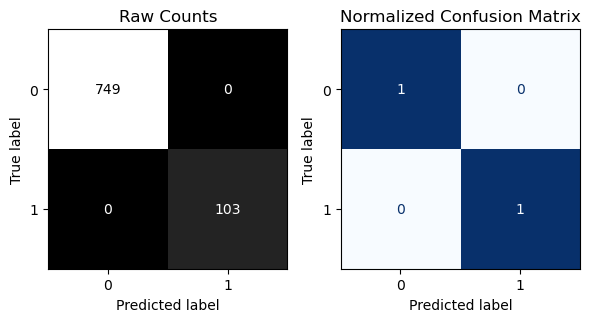


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       250
           1       0.12      0.03      0.05        34

    accuracy                           0.86       284
   macro avg       0.50      0.50      0.49       284
weighted avg       0.79      0.86      0.82       284



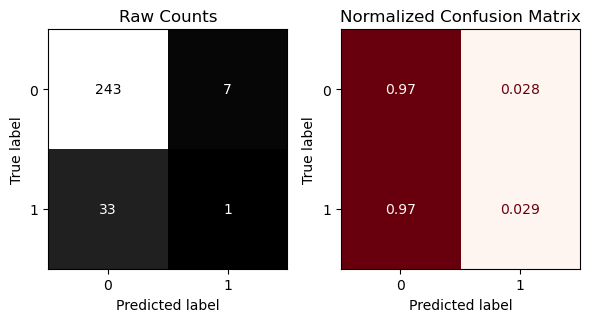

In [ ]:
results = evaluate_classification(rf_model_pipe,X_train, y_train, X_test, y_test,output_dict=True)


In [ ]:
rf_model_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['gender', 'ever_married', 'work_type', 'Residence_type',
          'smoking_status'],
         dtype='object'))],
                     verb

In [ ]:
rf_param_grid = {'randomforestclassifier__n_estimators': [10, 50, 100, 200], 'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
                 'randomforestclassifier__class_weight': [None, 'balanced']}
rf_param_grid = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_features': ['auto'],
    'randomforestclassifier__class_weight': ['balanced'],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__bootstrap': [True, False]
}

In [ ]:
rf_grid_search = GridSearchCV(rf_model_pipe, rf_param_grid, cv=3, scoring='recall_macro')
rf_grid_search.fit(X_train, y_train)
rf_grid_search.best_params_


{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       749
           1       0.62      1.00      0.77       103

    accuracy                           0.93       852
   macro avg       0.81      0.96      0.86       852
weighted avg       0.95      0.93      0.93       852



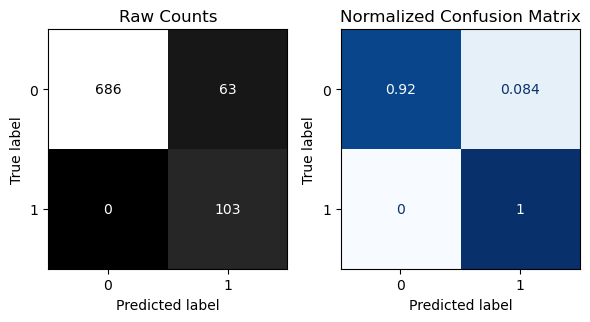


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       250
           1       0.35      0.65      0.45        34

    accuracy                           0.81       284
   macro avg       0.65      0.74      0.67       284
weighted avg       0.87      0.81      0.84       284



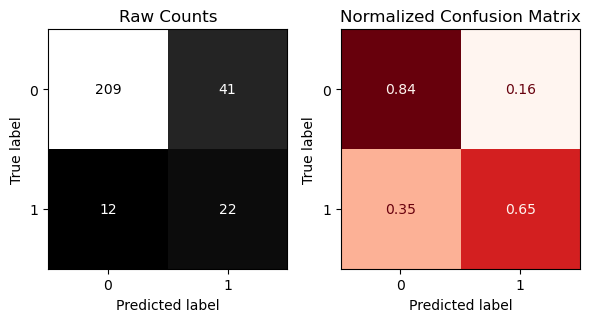

In [ ]:
# Evalaute the best model
rf_grid_search = rf_grid_search.best_estimator_
evaluate_classification(rf_grid_search, X_train, y_train, X_test, y_test)

### Which combination of hyperparameters led to the best-tuned model?


{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}0}

## Which of your models would you recommend for production? Which metric or metrics did you use to decide that, and why?


The Logistic Regression model has the highest recall for the minority class (Class 1,   stroke cases) at 0.85, which suggests it's the best at identifying stroke cases. Its macro average recall is also the highest, indicating good balance across classes in terms of recall.

Given the critical importance of identifying as many true stroke cases as possible (high recall for Class 1), the Logistic Regression model with hyperparameter tuning appears to be the best model among those listed. It offers the highest recall for detecting stroke cases, which is crucial for a medical diagnostic tool where missing a positive case can have serious consequences. However, it's also important to note that this model does trade off some accuracy and precision for this recall, as seen in its overall metrics. This trade-off is often acceptable in medical diagnosis contexts where false negatives (failing to detect a condition) are more costly than false positives (incorrectly diagnosing a condition that isn't present).